In [183]:
import os,sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

path = "C:/Users/hep22/9. 딥러닝 강의/tst/" #이미지 경로

os.chdir(path)

In [184]:
# Path to the data directory

data_dir = Path(path)

In [185]:
data_dir

WindowsPath('C:/Users/hep22/9. 딥러닝 강의/tst')

In [186]:
# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

In [187]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1070
Number of labels found:  1070
Number of unique characters:  62
Characters present:  {'O', '5', 'a', 'i', 'g', 'F', 'o', 'U', 'r', 'n', 'z', '0', 'd', '3', 'p', 'D', 'v', 'J', 't', 'V', 'j', 'M', 'h', 's', 'm', 'B', '6', 'w', 'X', 'K', 'Q', '9', 'l', 'G', 'e', 'Y', 'H', 'S', 'k', 'x', 'R', 'P', 'c', '2', '8', 'W', '7', 'T', 'f', 'Z', 'N', 'u', 'L', 'q', 'y', 'A', 'E', 'b', '1', '4', 'I', 'C'}


In [188]:
print(characters)

{'O', '5', 'a', 'i', 'g', 'F', 'o', 'U', 'r', 'n', 'z', '0', 'd', '3', 'p', 'D', 'v', 'J', 't', 'V', 'j', 'M', 'h', 's', 'm', 'B', '6', 'w', 'X', 'K', 'Q', '9', 'l', 'G', 'e', 'Y', 'H', 'S', 'k', 'x', 'R', 'P', 'c', '2', '8', 'W', '7', 'T', 'f', 'Z', 'N', 'u', 'L', 'q', 'y', 'A', 'E', 'b', '1', '4', 'I', 'C'}


In [189]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

In [190]:
list_characters = list(characters)

In [191]:
list_characters.sort()

In [192]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list_characters, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [193]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    ).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    ).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
)

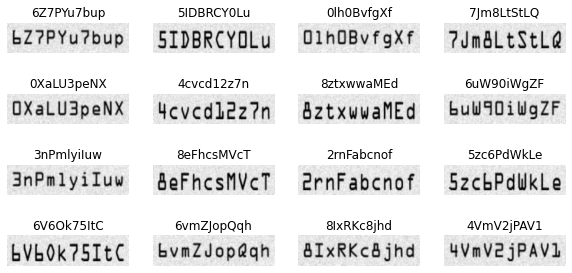

In [194]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [195]:
labels

<tf.Tensor: shape=(16, 10), dtype=int64, numpy=
array([[ 7, 36,  8, 26, 35, 57,  8, 38, 57, 52],
       [ 6, 19, 14, 12, 28, 13, 35,  1, 22, 57],
       [ 1, 48, 44,  1, 12, 58, 42, 43, 34, 42],
       [ 8, 20, 49,  9, 22, 56, 29, 56, 22, 27],
       [ 1, 34, 37, 22, 31,  4, 52, 41, 24, 34],
       [ 5, 39, 58, 39, 40,  2,  3, 62,  8, 50],
       [ 9, 62, 56, 60, 59, 59, 37, 23, 15, 40],
       [ 7, 57, 33, 10,  1, 45, 33, 43, 36, 16],
       [ 4, 50, 26, 49, 48, 61, 45, 19, 57, 59],
       [ 9, 41, 16, 44, 39, 55, 23, 32, 39, 30],
       [ 3, 54, 50, 16, 37, 38, 39, 50, 51, 42],
       [ 6, 62, 39,  7, 26, 40, 33, 47, 22, 41],
       [ 7, 32,  7, 25, 47,  8,  6, 19, 56, 13],
       [ 7, 58, 49, 36, 20, 51, 52, 27, 53, 44],
       [ 9, 19, 60, 28, 21, 39,  9, 46, 44, 40],
       [ 5, 32, 49, 32,  3, 46, 26, 11, 32,  2]], dtype=int64)>

In [196]:
print(train_dataset)

<PrefetchDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>


In [197]:
print(validation_dataset)

<PrefetchDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>


In [198]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [199]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
61/61 [==============================] - 35s 352ms/step - loss: 48.5591 - val_loss: 43.0398
Epoch 2/100
61/61 [==============================] - 22s 367ms/step - loss: 42.9112 - val_loss: 42.7744
Epoch 3/100
61/61 [==============================] - 19s 318ms/step - loss: 42.6440 - val_loss: 42.4867
Epoch 4/100
61/61 [==============================] - 19s 310ms/step - loss: 42.3720 - val_loss: 42.0985
Epoch 5/100
61/61 [==============================] - 20s 327ms/step - loss: 41.9735 - val_loss: 41.6656
Epoch 6/100
61/61 [==============================] - 32s 521ms/step - loss: 41.6740 - val_loss: 41.5022
Epoch 7/100
61/61 [==============================] - 24s 396ms/step - loss: 41.5564 - val_loss: 41.4233
Epoch 8/100
61/61 [==============================] - 23s 371ms/step - loss: 41.4575 - val_loss: 41.4625
Epoch 9/100
61/61 [==============================] - 29s 469ms/step - loss: 41.3087 - val_loss: 40.9773
Epoch 10/100
61/61 [==============================] - 31s 507ms/

61/61 [==============================] - 19s 304ms/step - loss: 0.1221 - val_loss: 0.0077
Epoch 81/100
61/61 [==============================] - 19s 313ms/step - loss: 0.1126 - val_loss: 0.0069
Epoch 82/100
61/61 [==============================] - 21s 337ms/step - loss: 0.1086 - val_loss: 0.0071
Epoch 83/100
61/61 [==============================] - 18s 301ms/step - loss: 0.1251 - val_loss: 0.0102
Epoch 84/100
61/61 [==============================] - 17s 281ms/step - loss: 0.1575 - val_loss: 0.0066
Epoch 85/100
61/61 [==============================] - 16s 270ms/step - loss: 0.0909 - val_loss: 0.0059
Epoch 86/100
61/61 [==============================] - 16s 269ms/step - loss: 0.1310 - val_loss: 0.0064
Epoch 87/100
61/61 [==============================] - 17s 274ms/step - loss: 0.1255 - val_loss: 0.0069
Epoch 88/100
61/61 [==============================] - 17s 285ms/step - loss: 0.0769 - val_loss: 0.0054
Epoch 89/100
61/61 [==============================] - 18s 297ms/step - loss: 0.0827 - 

In [148]:
###model.save('OCR_MODEL3.h5', include_optimizer=True)

In [200]:
model.save('OCR_MODEL_test_v2.h5', include_optimizer=True)

In [201]:
model

In [202]:
model2 = tf.keras.models.load_model('OCR_MODEL_test_v2.h5', custom_objects={'CTCLayer':CTCLayer})

In [203]:
model2

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)            492

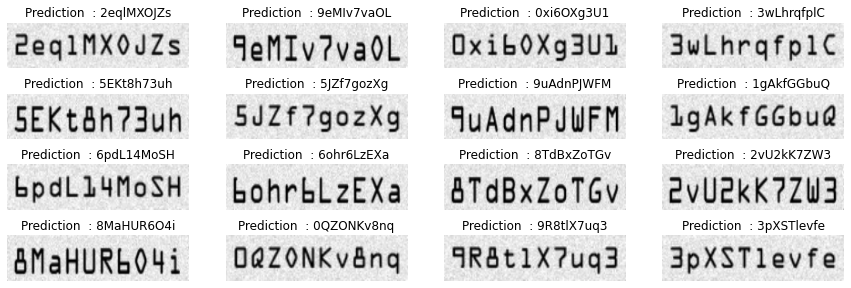

In [205]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model2.get_layer(name="image").input, model2.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction  : {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()